In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sqlalchemy import create_engine
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import sys
import os

# เพิ่มโฟลเดอร์ปัจจุบันเข้าไปใน sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# ตอนนี้จะ import ได้แล้ว
from src.database import get_db_engine

# ตั้งค่าเพื่อให้แสดงผลกราฟสวยงาม
plt.style.use('fivethirtyeight')
%matplotlib inline

In [7]:
engine = get_db_engine()

query = """
SELECT 
    pm.park_name_en,
    DATE(t_paid_datetime) AS sales_date,
    SUM(t_paid_amount) AS daily_revenue,
    EXTRACT(DOW FROM t_paid_datetime) AS day_of_week,
    COUNT(t_id) AS transaction_count
FROM transactions t
LEFT JOIN orders o ON o.o_id = t.o_id
LEFT JOIN items i ON i.o_id = o.o_id
LEFT JOIN parkings p ON i.i_id = p.i_id
LEFT JOIN parking_master pm ON pm.park_id = p.park_id
WHERE t.deleted_at IS NULL AND t_paid_datetime IS NOT NULL
GROUP BY pm.park_name_en, sales_date, day_of_week
ORDER BY pm.park_name_en, sales_date;
"""

df_raw = pd.read_sql(query, engine)
df_raw['sales_date'] = pd.to_datetime(df_raw['sales_date'])
print(f"Loaded {len(df_raw)} records.")
df_raw.head()

Loaded 3560 records.


,park_name_en,sales_date,daily_revenue,day_of_week,transaction_count
0,Bangkok Noi,2024-11-15,1.0,5.0,1
1,Bangkok Noi,2024-11-16,1380.0,6.0,50
2,Bangkok Noi,2024-11-17,2320.0,0.0,60
3,Bangkok Noi,2024-11-18,3520.0,1.0,71
4,Bangkok Noi,2024-11-19,5600.0,2.0,111


In [8]:
df = df_raw.copy()

# 1. สร้างมิติเวลา
df['month'] = df['sales_date'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 2. สร้าง Lag Features แยกตามแต่ละลาน (สำคัญมาก)
df['rev_lag_1'] = df.groupby('park_name_en')['daily_revenue'].shift(1)
df['rev_lag_7'] = df.groupby('park_name_en')['daily_revenue'].shift(7)

# 3. สร้าง Rolling Mean (เฉลี่ย 7 วันล่าสุด)
df['rev_rolling_7'] = df.groupby('park_name_en')['daily_revenue'].transform(lambda x: x.rolling(window=7).mean())

# 4. แปลงชื่อลานเป็นรหัสตัวเลข (Label Encoding)
df['park_name_en'] = df['park_name_en'].astype('category')
parking_mapping = dict(enumerate(df['park_name_en'].cat.categories))
df['park_id'] = df['park_name_en'].cat.codes

# ลบแถวที่มีค่าว่าง (จากการทำ Lag)
df_clean = df.dropna().sort_values('sales_date')
print(f"Data ready for training: {len(df_clean)} records.")

Data ready for training: 3373 records.


In [9]:
# เลือก Feature ที่จะใช้สอน
features = ['park_id', 'day_of_week', 'month', 'is_weekend', 'rev_lag_1', 'rev_lag_7', 'rev_rolling_7']
X = df_clean[features]
y = df_clean['daily_revenue']

# แบ่งข้อมูลแบบ Time-Series (ไม่ Shuffle)
split_point = int(len(df_clean) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Training size: {len(X_train)} | Testing size: {len(X_test)}")

Training size: 2698 | Testing size: 675


In [10]:
# ใช้ XGBoost Regressor
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:24534.68394	validation_1-rmse:27289.43871
[100]	validation_0-rmse:11756.04960	validation_1-rmse:14805.98546
[200]	validation_0-rmse:7718.92628	validation_1-rmse:11579.74435
[300]	validation_0-rmse:6389.63144	validation_1-rmse:10780.11087
[400]	validation_0-rmse:5732.89951	validation_1-rmse:10594.55650
[500]	validation_0-rmse:5293.94835	validation_1-rmse:10499.33256
[600]	validation_0-rmse:4957.72162	validation_1-rmse:10494.64762
[700]	validation_0-rmse:4668.10856	validation_1-rmse:10482.72504
[800]	validation_0-rmse:4388.57824	validation_1-rmse:10478.53075
[900]	validation_0-rmse:4142.31758	validation_1-rmse:10464.06667
[999]	validation_0-rmse:3932.28904	validation_1-rmse:10461.37275


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

MAE: 6358.84 THB
MAPE: 59.39 %


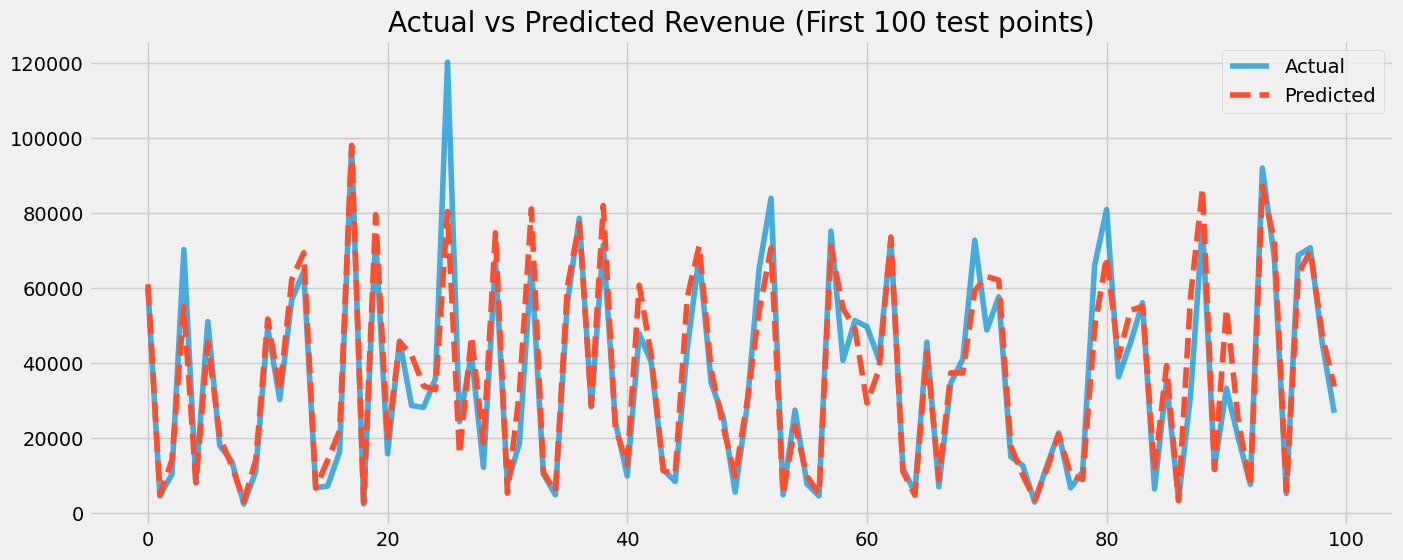

In [11]:
y_pred = model.predict(X_test)

# คำนวณ Error
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae:.2f} THB")
print(f"MAPE: {mape*100:.2f} %")

# พล็อตกราฟเปรียบเทียบ (เลือก 1 ลานมาดู)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Revenue (First 100 test points)')
plt.legend()
plt.show()

#

In [12]:
import os

# สร้างโฟลเดอร์ models ถ้ายังไม่มี
if not os.path.exists('../models'):
    os.makedirs('../models')

# บันทึก Model และ Mapping
joblib.dump(model, '../models/parking_model.pkl')
joblib.dump(parking_mapping, '../models/parking_mapping.pkl')

print("Successfully exported model and mapping to /models folder!")

Successfully exported model and mapping to /models folder!
